## User Tutorial

### Instillation of Dependant Packages

[Anaconda](https://www.continuum.io/) is recommended to create a Python environment within which to use ipymd:

    conda create -n ipymd -c cjs14 ipymd
    source activate ipymd
    ipython notebook

In [8]:
import ipymd
print(ipymd.version())

0.4.1dev


### Basic Atom Creation and Visualisation

The input for a basic atomic visualisation, is a [pandas](http://pandas.pydata.org/) Dataframe that specifies the coordinates, size and color of each atom in the following manner:

In [9]:
import pandas as pd
df = pd.DataFrame(
        [[2,3,4,1,[0, 0, 255],1],
         [1,3,3,1,'orange',1],
         [4,3,1,1,'blue',1]],
        columns=['x','y','z','radius','color','transparency'])

Distances are measured in Angstroms, and colors can be defined in [r,g,b] format (0 to 255) or as a string defined in `available_colors`.

In [10]:
print(ipymd.available_colors()['reds'])

['light_salmon', 'salmon', 'dark_salmon', 'light_coral', 'indian_red', 'crimson', 'fire_brick', 'dark_red', 'red']


The `Visualise_Sim` class can then be used to setup a visualisation, which is returned in the form of a `PIL` image.

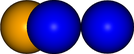

In [11]:
vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_atoms(df)
img1 = vis.get_image(size=400,quality=5)
img1

To convert this into an image viewable in IPython, simply parse it to the `visualise` function.

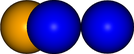

In [12]:
vis.visualise(img1)

Extending this basic procedure, additional objects can be added to the visualisation, the viewpoint can be rotated and multiple images can be output at once, as shown in the following example:

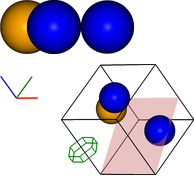

In [13]:
vis.add_axes(length=0.2, offset=(-0.3,0))
vis.add_box([[5,0,0],[0,5,0],[0,0,5]])
vis.add_plane([[5,0,0],[0,5,2]],alpha=0.3)
vis.add_hexagon([[1,0,0],[0,0,.5]],[0,0,2],color='green')

img2 = vis.get_image(xrot=45, yrot=45)
#img2 = vis.draw_colorlegend(img2,1,2)
vis.visualise([img1,img2])

Images can also be added to plots, with the `Plotter` class:

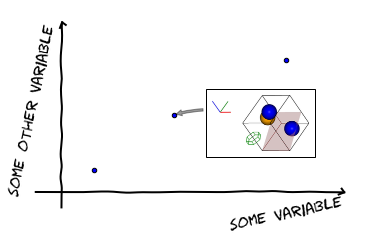

In [14]:
plot = ipymd.plotting.Plotter(figsize=(5,3))
plot.axes.scatter([0,0.5,1.2],[0,0.5,1])
plot.axes.set_xlabel('some variable')
plot.axes.set_ylabel('some other variable')
plot.add_image_annotation(img2,(250,100),(0.5,0.5),zoom=0.5)
#plot.resize_axes(width=0.5)
plot.apply_xkcd_style()
plot.display_plot(tight_layout=True)


### Atom Creation From Other Sources

The `ipymd.data_input` module includes a number of classes to automate the intial creation of the atoms Dataframe, from various sources. Most classes will return a sub-class of `DataInput`, with a `get_atoms` method to return the atoms Dataframe and a `get_simulation_box` method to return the vertexes and origin of the simulation box.

#### Crystal Parameters

This class allows atoms to be created in ordered crystal, as defined by their space group and crystal parameters:

In [15]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[5.4, 5.4, 5.4, 90, 90, 90], 
    repetitions=[5, 5, 5])

sim_abc, sim_origin = data.get_simulation_box()
print(sim_origin)
print(sim_abc)
atoms_df = data.get_atom_data()
atoms_df.head(2)

[ 0.  0.  0.]
[[  2.70000000e+01   0.00000000e+00   0.00000000e+00]
 [  1.65327318e-15   2.70000000e+01   0.00000000e+00]
 [  1.65327318e-15   1.65327318e-15   2.70000000e+01]]


,id,type,x,y,z,transparency,color,radius
0,1,Na,0.000000e+00,0.0,0.0,1.0,light_salmon,1.0
1,2,Na,3.306546e-16,2.7,2.7,1.0,light_salmon,1.0


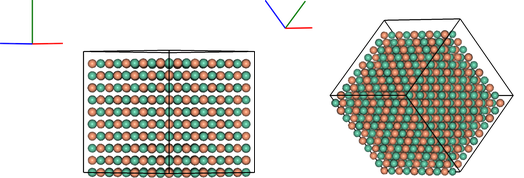

In [16]:
vis2 = ipymd.visualise_sim.Visualise_Sim()
vis2.add_axes()
vis2.add_box(sim_abc, sim_origin)
vis2.add_atoms(atoms_df)
images = [vis2.get_image(xrot=xrot,yrot=45) for xrot in [0,45]]
vis2.visualise(images, columns=2)

A dataframe is available which lists the alternative names for each space group:

In [17]:
df = ipymd.data_input.crystal.get_spacegroup_df()
df.loc[[1,194,225]]

,System_type,Point group,Short_name,Full_name,Schoenflies,Fedorov,Shubnikov,Fibrifold
Number,,,,,,,,
1,triclinic,1,P1,P 1,$C_1^1$,1s,$(a/b/c)\cdot 1$,-
194,hexagonal,6/m 2/m 2/m,P63/mmc,P 63/m 2/m 2/c,$D_{6h}^4$,88a,$(c:(a/a))\cdot m:6_3\cdot m$,-
225,cubic,4/m 3 2/m,Fm3m,F 4/m 3 2/m,$O_h^5$,73s,$\left ( \frac{a+c}{2}/\frac{b+c}{2}/\frac{a+b...,$2^{-}:2$


#### Crystallographic Information Files

.cif files are a common means to store crystallographic data and can be loaded as follows:

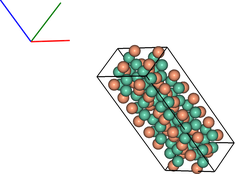

In [18]:
cif_path = ipymd.get_data_path('example_crystal.cif')
data = ipymd.data_input.cif.CIF(cif_path)
vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(), data.get_simulation_box(),
              xrot=45,yrot=45)

NB: at present, fractional occupancies of lattice sites are returned in the atom Dataframe, but cannot be visualised as such. It is intended that eventually occupancy will be visualised by partial spheres. 

In [19]:
data.get_atom_data().head(1)

,type,x,y,z,occupancy,transparency,color,radius
0,Fe,4.363536,2.40065,22.642804,1.0,1.0,light_salmon,1.0


#### Lammps Input Data

The input data for LAMMPS simulations (supplied to `read_data`) can be input. Note that the `get_atom_data` method requires that the atom_style is defined, in order to define what each data column refers to.

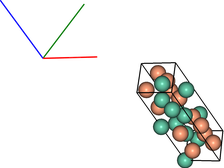

In [20]:
lammps_path = ipymd.get_data_path('lammps_input.data')
data = ipymd.data_input.lammps.LAMMPS_Input(lammps_path)

vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(atom_style='charge'), data.get_simulation_box(),xrot=45,yrot=45)

#### Lammps Output Data

Output data can be read in the form of a single file or, it is advisable for efficiency, that a single file is output for each timestep, where `*` is used to define the variable section of the filename. The `get_atoms` and `get_simulation_box` methods not take a variable to define which timestep is returned.

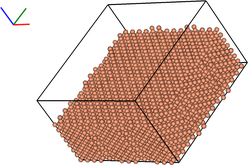

In [21]:
lammps_path = ipymd.get_data_path('atom_onefile.dump')
data = ipymd.data_input.lammps.LAMMPS_Output(lammps_path)

vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(98), data.get_simulation_box(98),
              spheres=True,xrot=45,yrot=45,quality=5)

98


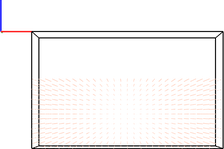

In [22]:
lammps_path = ipymd.get_data_path(['atom_dump','atoms_*.dump'])
data = ipymd.data_input.lammps.LAMMPS_Output(lammps_path)
print(data.count_timesteps())

vis = ipymd.visualise_sim.Visualise_Sim()
vis.basic_vis(data.get_atom_data(98), data.get_simulation_box(98),
              spheres=False,xrot=90,yrot=0)

### Atom Manipulation

The atoms Dataframe is already very easy to manipulate using the standard [pandas](http://pandas.pydata.org/) methods. But an `Atom_Manipulation` class has also been created to carry out standard atom manipulations, such as setting variables dependant on atom type or altering the geometry, as shown in this example:

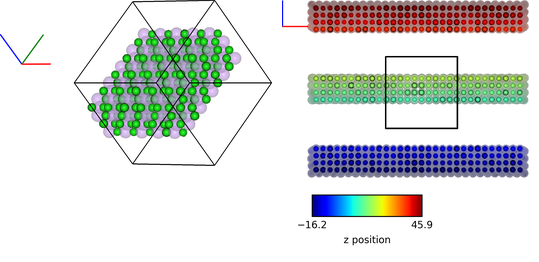

In [23]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[5.4, 5.4, 5.4, 90, 90, 90], 
    repetitions=[5, 5, 5])

manipulate_atoms = ipymd.atom_manipulation.Atom_Manipulation

new_df = manipulate_atoms(data.get_atom_data(),undos=2)

new_df.apply_map({'Na':1.5, 'Cl':1},'radius')
new_df.apply_map('color','color',default='grey')
new_df.change_type_variable('Na', 'transparency', 0.5)
new_df.slice_z(10,20)

vis2 = ipymd.visualise_sim.Visualise_Sim()
vis2.add_box(*data.get_simulation_box())
vis2.add_axes(offset=(-1.3,-0.7))
vis2.add_atoms(new_df.df, spheres=True)

img1 = vis2.get_image(xrot=45,yrot=45)

vis2.remove_atoms()
new_df.repeat_cell(data.get_simulation_box()[0],((-1,1),(-1,1),(-1,1)))
new_df.color_by_variable('z')
vis2.add_atoms(new_df.df, spheres=True)
img2 = vis2.get_image(xrot=90,yrot=0)

img3 = ipymd.plotting.create_colormap_image(new_df.df.z.min(), new_df.df.z.max(),
                                            horizontal=True,title='z position',size=150)

vis2.visualise([img1,img2, (280,1), img3], columns=2)

NB: default atom variables (such as color and radii can be set using the `apply_map` method and any column name from those given in `ipymd.shared.atom_data()`: 

In [24]:
ipymd.shared.atom_data().head(1)

,Num,ARENeg,RCov,RBO,RVdW,MaxBnd,Mass,ElNeg,Ionization,ElAffinity,Name,color_chemlab,color_chemlab_light,color
Symb,,,,,,,,,,,,,,
H,1,2.2,0.31,0.31,1.1,1,1.00794,2.2,13.5984,0.754204,Hydrogen,white,snow,"(191, 191, 191)"


### Geometric Analysis

Given the simple and flexible form of the atomic data and visualisation, it is now easier to add more complex geometric analysis. These analyses are being contained in the `atom_analysis` package, and some initial examples are detailed below. Functions in the `atom_analysis.nearest_neighbour` package are based on the `scipy.spatial.cKDTree` algorithm for identifying nearest neighbours.

#### Atomic Coordination

The two examples below show computation of the coordination of Na, w.r.t Cl, in a simple NaCl crystal (which should be 6). The first does not include a consideration of the repeating boundary conditions, and so outer atoms have a lower coordination number. But the latter computation provides a method which takes this into consideration, by repeating the Cl lattice in each direction before computation.

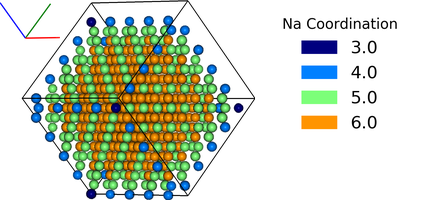

In [25]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[5.4, 5.4, 5.4, 90, 90, 90], 
    repetitions=[5, 5, 5])
df = data.get_atom_data()

df = ipymd.atom_analysis.nearest_neighbour.coordination_bytype(df, 'Na','Cl')

new_df = manipulate_atoms(df)
new_df.filter_variables('Na')
new_df.color_by_variable('coord_Na_Cl',minv=3,maxv=7)

vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_axes(offset=(0,-0.3))
vis.add_box(*data.get_simulation_box())
vis.add_atoms(new_df.df)

img = vis.get_image(xrot=45,yrot=45)

img2 = ipymd.plotting.create_legend_image(new_df.df.coord_Na_Cl,new_df.df.color, title='Na Coordination',size=150,colbytes=True)

vis.visualise([img,img2],columns=2)

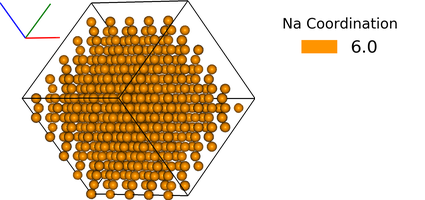

In [26]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[5.4, 5.4, 5.4, 90, 90, 90], 
    repetitions=[5, 5, 5])
df = data.get_atom_data()

df = ipymd.atom_analysis.nearest_neighbour.coordination_bytype(
    df, 'Na','Cl',repeat_vectors=data.get_simulation_box()[0])

new_df = manipulate_atoms(df)
new_df.filter_variables('Na')
new_df.color_by_variable('coord_Na_Cl',minv=3,maxv=7)

vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_box(*data.get_simulation_box())
vis.add_axes(offset=(0,-0.3))
vis.add_atoms(new_df.df)

img = vis.get_image(xrot=45,yrot=45)

img2 = ipymd.plotting.create_legend_image(new_df.df.coord_Na_Cl,new_df.df.color, title='Na Coordination',size=150,colbytes=True)

vis.visualise([img,img2],columns=2)

#### Atomic Structure Comparison

`compare_to_lattice` takes each atomic coordinate in df1 and computes the distance to the nearest atom (i.e. lattice site) in df2:

In [27]:
import numpy as np
data1 = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[5.4, 5.4, 5.4, 90, 90, 90], 
    repetitions=[5, 5, 5])
df1 = data1.get_atom_data()

print(('Average distance to nearest atom (identical)', 
       np.mean(ipymd.atom_analysis.nearest_neighbour.compare_to_lattice(df1,df1))))

data2 = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]], ['Na', 'Cl'], 
    225, cellpar=[5.41, 5.4, 5.4, 90, 90, 90], 
    repetitions=[5, 5, 5])
df2 = data2.get_atom_data()

print(('Average distance to nearest atom (different)', 
       np.mean(ipymd.atom_analysis.nearest_neighbour.compare_to_lattice(df1,df2))))


('Average distance to nearest atom (identical)', 0.0)
('Average distance to nearest atom (different)', 0.022499999999999343)


#### Common Neighbour Analysis (CNA)

CNA ([Honeycutt and Andersen, J. Phys. Chem. 91, 4950](http://dx.doi.org/10.1021/j100303a014)) is an algorithm to compute a signature for pairs of atoms, which is designed to characterize the local structural environment. Typically, CNA is used as an effective filtering method to classify atoms in crystalline systems ([Faken and Jonsson, Comput. Mater. Sci. 2, 279](http://dx.doi.org/10.1016/0927-0256(94%2990109-0)), with the goal to get a precise understanding of which atoms are associated with which phases, and which are associated with defects.

Common signatures for nearest neighbours are:

- FCC = 12 x 4,2,1
- HCP = 6 x 4,2,1 & 6 x 4,2,2
- BCC = 6 x 6,6,6 & 8 x 4,4,4
- Diamond = 12 x 5,4,3 & 4 x 6,6,3

which are tested below:

In [28]:
data = ipymd.data_input.crystal.Crystal(
    [[0.0, 0.0, 0.0]], ['Al'], 
    225, cellpar=[4.05, 4.05, 4.05, 90, 90, 90], 
    repetitions=[5, 5, 5])
fcc_vector = data.get_simulation_box()[0]
fcc_df = data.get_atom_data()

data = ipymd.data_input.crystal.Crystal(
    [[0.33333,0.66667,0.25000]], ['Mg'], 
    194, cellpar=[3.21, 3.21, 5.21, 90, 90, 120], 
    repetitions=[5,5,5])
hcp_vector = data.get_simulation_box()[0]
hcp_df = data.get_atom_data()

data = ipymd.data_input.crystal.Crystal(
    [[0,0,0]], ['Fe'], 
    229, cellpar=[2.866, 2.866, 2.866, 90, 90, 90], 
    repetitions=[5,5,5])
bcc_vector = data.get_simulation_box()[0]
bcc_df = data.get_atom_data()

data = ipymd.data_input.crystal.Crystal(
    [[0,0,0]], ['C'], 
    227, cellpar=[3.57, 3.57, 3.57, 90, 90, 90], 
    repetitions=[2,2,2])
diamond_vector = data.get_simulation_box()[0]
diamond_df = data.get_atom_data()

In [29]:
print(ipymd.atom_analysis.nearest_neighbour.cna_sum(fcc_df,repeat_vectors=fcc_vector))
print(ipymd.atom_analysis.nearest_neighbour.cna_sum(hcp_df,repeat_vectors=hcp_vector))
print(ipymd.atom_analysis.nearest_neighbour.cna_sum(bcc_df,repeat_vectors=bcc_vector))
print(ipymd.atom_analysis.nearest_neighbour.cna_sum(diamond_df,upper_bound=10,max_neighbours=16,repeat_vectors=diamond_vector))

Counter({'4,2,1': 6000})
Counter({'4,2,2': 1500, '4,2,1': 1500})
Counter({'6,6,6': 2000, '4,4,4': 1500})
Counter({'5,4,3': 768, '6,6,3': 256})


For each atom, the CNA for each nearest-neighbour can be output:

In [30]:
ipymd.atom_analysis.nearest_neighbour.common_neighbour_analysis(hcp_df,repeat_vectors=hcp_vector).head(5)

,id,type,x,y,z,transparency,color,radius,cna
0,1,Mg,-0.000016,1.853304,1.3025,1.0,light_salmon,1.0,"{u'4,2,2': 6, u'4,2,1': 6}"
1,2,Mg,1.605016,0.926638,3.9075,1.0,light_salmon,1.0,"{u'4,2,2': 6, u'4,2,1': 6}"
2,3,Mg,-0.000016,1.853304,6.5125,1.0,light_salmon,1.0,"{u'4,2,2': 6, u'4,2,1': 6}"
3,4,Mg,1.605016,0.926638,9.1175,1.0,light_salmon,1.0,"{u'4,2,2': 6, u'4,2,1': 6}"
4,5,Mg,-0.000016,1.853304,11.7225,1.0,light_salmon,1.0,"{u'4,2,2': 6, u'4,2,1': 6}"


This can be used to produce a plot identifying likely structure of an unknown structure:

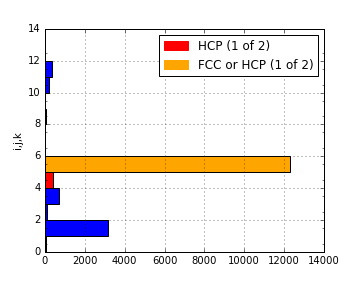

In [31]:
lammps_path = ipymd.get_data_path('thermalized_troilite.dump')
data = ipymd.data_input.lammps.LAMMPS_Output(lammps_path)
df = data.get_atom_data(0)
df = df[df.type==1]
plot = ipymd.atom_analysis.nearest_neighbour.cna_plot(df,repeat_vectors=data.get_simulation_box(0)[0])
plot.display_plot()

A visualisation of the probable local character of each atom can also be created. Note the *accuracy* parameter in the `cna_categories` method allows for more robust fitting to the ideal signatures:

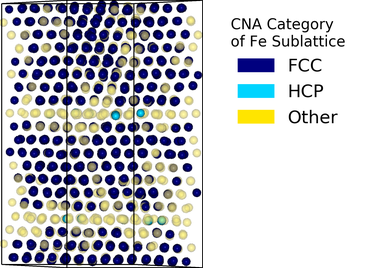

In [32]:
lammps_path = ipymd.get_data_path('thermalized_troilite.dump')
data = ipymd.data_input.lammps.LAMMPS_Output(lammps_path)

df = data.get_atom_data()
df = df[df.type==1]
df = ipymd.atom_analysis.nearest_neighbour.cna_categories(
    df,repeat_vectors=data.get_simulation_box()[0],accuracy=0.7)
manip = ipymd.atom_manipulation.Atom_Manipulation(df)
manip.color_by_categories('cna')
#manip.apply_colormap({'Other':'blue','FCC':'green','HCP':'red'}, type_col='cna')
manip.change_type_variable('Other','transparency',0.5,type_col='cna')
atom_df = manip.df

vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_box(*data.get_simulation_box())
vis.add_atoms(atom_df)

img = vis.get_image(xrot=90)

img2 = ipymd.plotting.create_legend_image(atom_df.cna,atom_df.color, 
                title='CNA Category\nof Fe Sublattice',size=150,colbytes=True)

vis.visualise([img,img2],columns=2)

#### Vacany Identification

The `vacancy_identification` method finds grid sites with no atoms within a specified distance:

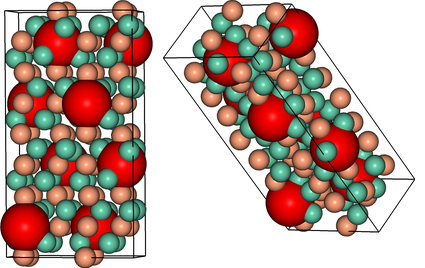

In [33]:
cif_path = ipymd.get_data_path('pyr_4C_monoclinic.cif')
data = ipymd.data_input.cif.CIF(cif_path)
cif4c_df, (cif4c_abc, cif4c_origin) = data.get_atom_data(), data.get_simulation_box()
vac_df = ipymd.atom_analysis.nearest_neighbour.vacancy_identification(cif4c_df,0.2,2.3,cif4c_abc,
                                         radius=2.3,remove_dups=True)
vis = ipymd.visualise_sim.Visualise_Sim()
vis.add_atoms(vac_df)
vis.add_box(cif4c_abc)
vis.add_atoms(cif4c_df)
vis.visualise([vis.get_image(xrot=90,yrot=10),
               vis.get_image(xrot=45,yrot=45)],columns=2)

#### XRD Spectrum Prediction

This is an implementation of the virtual x-ray diffraction pattern algorithm, from http://http://dx.doi.org/10.1007/s11837-013-0829-3.

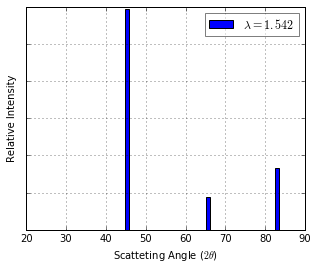

In [34]:
data = ipymd.data_input.crystal.Crystal(
    [[0,0,0]], ['Fe'], 
    229, cellpar=[2.866, 2.866, 2.866, 90, 90, 90], 
    repetitions=[5,5,5])

sim_abc, sim_origin = data.get_simulation_box()
atoms_df = data.get_atom_data()

wlambda = 1.542 # Angstrom (Cu K-alpha)
thetas, Is = ipymd.atom_analysis.spectral.compute_xrd(atoms_df,sim_abc,wlambda)
plot = ipymd.atom_analysis.spectral.plot_xrd_hist(thetas,Is,wlambda=wlambda,barwidth=1)
plot.axes.set_xlim(20,90)
plot.display_plot(True)

The predicted spectrum peaks (for alpha-Fe) shows good correlation with experimentally derived data:

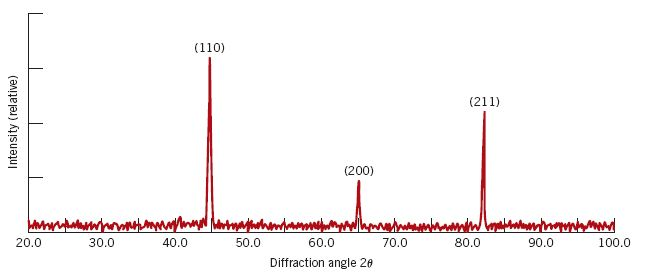

In [35]:
from IPython.display import Image
exp_path = ipymd.get_data_path('xrd_fe_bcc_Cu_kalpha.png',
                          module=ipymd.atom_analysis)
Image(exp_path,width=380)

### System Analysis

Within the `LAMMPS_Output` class there is also the option to read in a systems data file, with a log of global variables for each simulation timestep.

In [36]:
data = ipymd.data_input.lammps.LAMMPS_Output(
    sys_path=ipymd.get_data_path('system.dump'))

In [37]:
sys_data = data.get_system_data()
sys_data.tail()

,time,natoms,a,b,vol,press,temp,peng,keng,teng,enth
94,18800,5880,4.000919,4.000920,106961.684112,3984.476256,20.821004,-576758.385663,364.871078,-576393.514586,-570178.024689
95,19000,5880,4.002667,4.002667,107055.104770,3457.822223,20.543535,-576743.788115,360.008650,-576383.779465,-570985.120033
96,19200,5880,3.995696,3.995696,106682.545808,1880.020740,14.949236,-576635.072775,261.973143,-576373.099632,-573448.059018
97,19400,5880,3.990131,3.990134,106385.666301,499.341106,21.315529,-576735.710976,373.537223,-576362.173753,-575587.433134
98,19600,5880,3.979611,3.979609,105825.294988,-2300.315883,17.161320,-576652.409368,300.738098,-576351.671270,-579901.871560


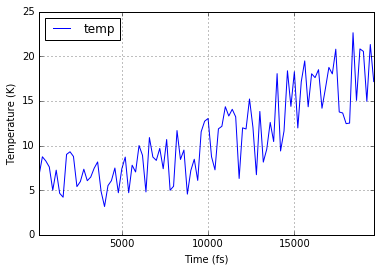

In [38]:
ax = sys_data.plot('time','temp')
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Temperature (K)');
ax.grid()